In [ ]:
import Pkg; Pkg.add("RandomMatrix")

In [57]:
using LinearAlgebra
using PyPlot
using RandomMatrix

In [58]:
function SvN(psi, l)
    
    D = size(psi)[1]
    logD = log2(D)
    @assert isinteger(logD) "State vector of incompatible length"
    L = Int(logD) # How many qubits in the state?
    @assert l>0 && l<L "Invalid bipartition", L


    psi_matrix = reshape(psi, (2^l,2^(L-l)))
    U,s,V = svd(psi_matrix)
    s = s[s .> 1e-14] # choosing non-zero singular values
    w = s.^2
    return -sum(w.*log.(w))
end


SvN (generic function with 1 method)

  0.239333 seconds (318.87 k allocations: 16.362 MiB, 56.14% gc time, 99.78% compilation time)
  0.000024 seconds (16 allocations: 3.906 KiB)
  0.000031 seconds (16 allocations: 7.594 KiB)
  0.000096 seconds (16 allocations: 17.109 KiB)
  0.000531 seconds (16 allocations: 53.969 KiB)
  0.002871 seconds (19 allocations: 202.703 KiB)
  0.013397 seconds (19 allocations: 788.328 KiB)
  0.049387 seconds (20 allocations: 3.042 MiB)
  0.206642 seconds (21 allocations: 12.079 MiB)
  1.035231 seconds (21 allocations: 48.154 MiB, 0.68% gc time)


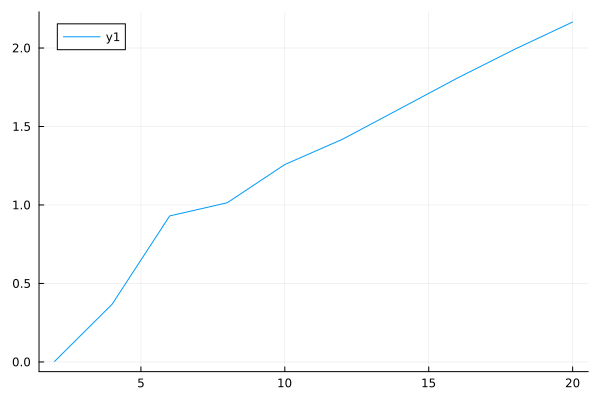

In [59]:
Ls = range(2, stop=20, step=2)
s = zeros(length(Ls))
for (i,L) in enumerate(Ls)
    D = 2^L
    psi = rand(D);
    psi ./= norm(psi);
    @time s[i] = SvN(psi, Int(L/2))
end 
plot(Ls,s)

In [60]:
function OneQubitU!(psi, i, U)

    D = size(psi)[1]
    
    for a in 0:D-1
        
        # Act on pairs of states with i'th bit on and off
        
        if (a & (1<<(i-1))>0 ) # Check if i'th bit is on
            continue
        end

        b = a + ( 1<<(i-1) )
        
        v = [ psi[a+1]; psi[b+1] ]
        v1 = U*v
        psi[a+1] = v1[1]
        psi[b+1] = v1[2]
        
    end
end

OneQubitU! (generic function with 1 method)

In [61]:
function TwoQubitU!(psi, i, j, U)
    
    D = size(psi)[1]
    
    for a in 0:D-1
        if ( a & (1<<(i-1)) > 0 ) || ( a & (1<<(j-1)) > 0 )
            continue
        end

        b = a+(1<<(i-1))
        c = a+(1<<(j-1))
        d = a+(1<<(i-1))+(1<<(j-1))   

        v = [ psi[a+1]; psi[b+1]; psi[c+1]; psi[d+1] ]
        v1 = U*v
        psi[a+1] = v1[1]
        psi[b+1] = v1[2]
        psi[c+1] = v1[3]
        psi[d+1] = v1[4]
    end
end

TwoQubitU! (generic function with 1 method)

## Testing the affect of one qubit random gates

In [62]:
L = 10

N = 100
s = zeros(N)

psi = zeros(ComplexF64, 2^L)
psi[1] = 1.

for n=1:N
    i = rand(1:L)
    U = randUnitary(2) # single qubit
    OneQubitU!(psi, i, U)
    s[n] = SvN(psi, Int(L/2))
end


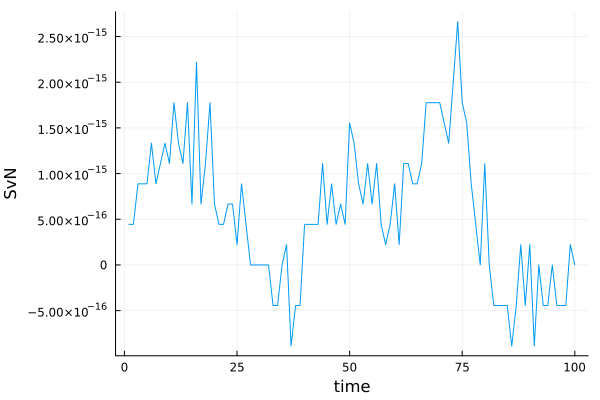

In [63]:
plot(s, xlabel="time", ylabel="SvN", legend = false)

starting with a pure state, sinle-qubit gates do not create entanglement!

## Testing the affect of two qubit random gates

In [64]:
L = 16
N = 40
s = zeros(N)

psi = zeros(ComplexF64, 2^L)
psi[1] = 1.

for n=1:N
    for i=1:2:L-1 # brick-wall circuit
        U = randUnitary(4) # two qubit    
        if n % 2 == 1
            TwoQubitU!(psi, i, i+1, U)
        elseif i<=L-2
            TwoQubitU!(psi, i+1, i+2, U)
        end
    end
    s[n] = SvN(psi, Int(L/2))
end

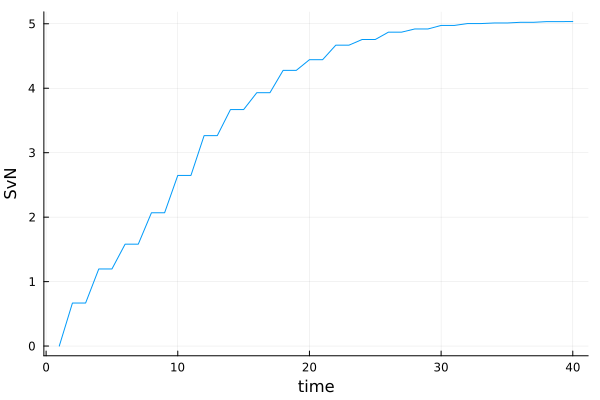

In [65]:
plot(s, xlabel="time", ylabel="SvN", legend = false)

In [66]:
# value at saturation vs system size -> volume law
Ls = 6:2:16
N = 40
s = zeros(length(Ls))

for (j, L) in enumerate(Ls)
    psi = zeros(ComplexF64, 2^L)
    psi[1] = 1.

    for n=1:N
        for i=1:2:L-1 # brick-wall circuit
            U = randUnitary(4) # two qubit    
            if n % 2 == 1
                TwoQubitU!(psi, i, i+1, U)
            elseif i<=L-2
                TwoQubitU!(psi, i+1, i+2, U)
            end
        end
    end
    s[j] = SvN(psi, Int(L/2))
end



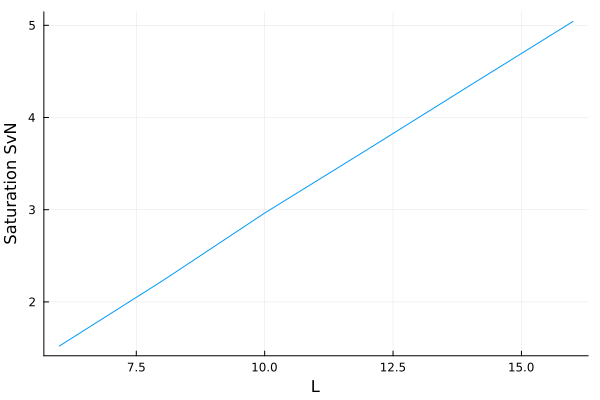

In [67]:
plot(Ls, s, xlabel="L", ylabel="Saturation SvN", legend = false)

## CAT states

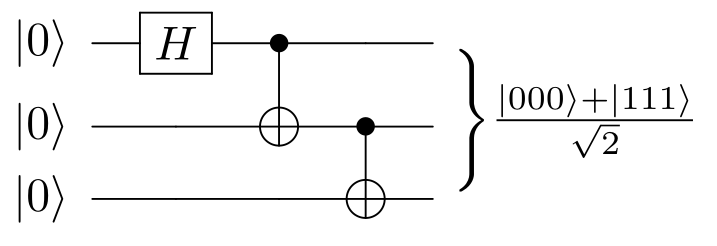

In [68]:
H = [1 1; 1 -1]/sqrt(2)

2×2 Matrix{Float64}:
 0.707107   0.707107
 0.707107  -0.707107

In [69]:
CNOT = [1 0 0 0; 0 1 0 0; 0 0 0 1; 0 0 1 0]

4×4 Matrix{Int64}:
 1  0  0  0
 0  1  0  0
 0  0  0  1
 0  0  1  0

In [70]:
psi = [1.; 0; 0; 0] # down down 2 qubit state
OneQubitU!(psi,1, H)
psi

4-element Vector{Float64}:
 0.7071067811865475
 0.7071067811865475
 0.0
 0.0

In [71]:
TwoQubitU!(psi,2,1,CNOT)
psi

4-element Vector{Float64}:
 0.7071067811865475
 0.0
 0.0
 0.7071067811865475

In [72]:
SvN(psi, 1)

0.6931471805599454